<h1 align="center"> Group 17 </h1> 

<h2>Presentors :
<br>Pranjal Jain
<br>Samratsinh Dhumal
<br>Snigdh Chandra</h2>

## Phase 1:Creating Database.

### importing packages

In [ ]:
import os
import re
import csv
import sqlite3
from sqlite3 import Error
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
plt.style.use('fivethirtyeight')
import seaborn as sns
from datetime import datetime
import plotly.express as px
import plotly.graph_objects as go
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
from IPython.display import clear_output
%matplotlib inline

### Connecting to SQLite Function

In [ ]:
def create_connection(db_file, delete_db=False):
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)
    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn

### Creating New Table Function

In [ ]:
def create_table(conn, create_table_sql):
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)

### Selecting from Table Function

In [ ]:
def select(conn,selct_sql):
    cur = conn.cursor()
    try:
        cur.execute(selct_sql)
        names = list(map(lambda x: x[0], cur.description))
        rows = cur.fetchall()
    except Error as e:
        names = e
        rows = []
    return [names,rows]

### Deleting from Table Function

In [ ]:
def delete(conn,delete_sql):
    cur = conn.cursor()
    try:
        cur.execute(delete_sql)
        print("deleted")
    except Error as e:
        print("not deleted")

### Update Table function

In [ ]:
def update(conn,update_sql):
    cur = conn.cursor()
    try:
        cur.execute(update_sql)
        #names = list(map(lambda x: x[0], cur.description))
        #rows = cur.fetchall()
        conn.commit()
    except Error as e:
        print("Failed to update")

### Create View

In [7]:
def create_view(conn, create_view_sql):
    try:
        c = conn.cursor()
        c.execute(create_view_sql)
    except Error as e:
        print(e)

### Converting csv File to SQLite File Function

In [8]:
def save_as_sql(file,conn,table_name,index=False):
    read_csv = pd.read_csv(file)
    read_csv.to_sql(table_name, conn, index)

## Creating Connection

In [9]:
conn = create_connection('weather_data',True)

## Saving Tables

In [10]:
'''save_as_sql('Dataset/historical-hourly-weather-data/city_attributes.csv',conn,'cities',False)
save_as_sql('Dataset/historical-hourly-weather-data/humidity.csv',conn,'humidity',False)
save_as_sql('Dataset/historical-hourly-weather-data/pressure.csv',conn,'pressure',False)
save_as_sql('Dataset/historical-hourly-weather-data/temperature.csv',conn,'temperature',False)
save_as_sql('Dataset/historical-hourly-weather-data/weather_description.csv',conn,'weather_description',False)
save_as_sql('Dataset/historical-hourly-weather-data/wind_direction.csv',conn,'wind_direction',False)
save_as_sql('Dataset/historical-hourly-weather-data/wind_speed.csv',conn,'wind_speed',False)
save_as_sql('Dataset/USA_Historical_Tornado.csv',conn,'USA_Historical_Tornado',False)
save_as_sql('Dataset/USA_CityCoordinates.csv',conn,'USA_City_Coordinates',False)'''

save_as_sql('humidity.csv',conn,'humidity',False)
save_as_sql('city_attributes.csv',conn,'cities',False)
save_as_sql('pressure.csv',conn,'pressure',False)
save_as_sql('temperature.csv',conn,'temperature',False)
save_as_sql('weather_description.csv',conn,'weather_description',False)
save_as_sql('wind_direction.csv',conn,'wind_direction',False)
save_as_sql('wind_speed.csv',conn,'wind_speed',False)
save_as_sql('USA_Historical_Tornado.csv',conn,'USA_Historical_Tornado',False)
save_as_sql('USA_CityCoordinates.csv',conn,'USA_City_Coordinates',False)

/Applications/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:2712: UserWarning:

The spaces in these column names will not be changed. In pandas versions < 0.14, spaces were converted to underscores.



## Data Cleaning Process

### deleting cities other than USA, empty rows, and cities with major missing values

In [11]:
delete(conn,"DELETE FROM cities WHERE country != 'United States'")
delete(conn,"DELETE FROM cities WHERE City = 'San Francisco'")
delete(conn,"DELETE FROM cities WHERE City = 'Miami'")
delete(conn,"DELETE FROM cities WHERE City = 'New York'")
delete(conn,"Delete FROM humidity where datetime = '2012-10-01 12:00:00'")
delete(conn,"Delete FROM pressure where datetime = '2012-10-01 12:00:00'")
delete(conn,"Delete FROM wind_speed where datetime = '2012-10-01 12:00:00'")
delete(conn,"Delete FROM wind_direction where datetime = '2012-10-01 12:00:00'")
delete(conn,"Delete FROM temperature where datetime = '2012-10-01 12:00:00'")

deleted
deleted
deleted
deleted
deleted
deleted
deleted
deleted
deleted


### Selcting all Cities of USA

In [12]:
[names,city_name] = select(conn,"Select city from cities")

### Updating Null Values in Tables

In [13]:
for city in city_name:
    humidity_nullvalues_update = """Update humidity set ["""+city[0]+"""] = (SELECT avg_val 
                                    from (Select AVG(h2.["""+city[0]+"""]) as avg_val, Substr(h2.datetime,1,7) 
                                    as tdatet FROM humidity as h2 group by Substr(h2.datetime,1,7)) as temp1 
                                    where Substr(humidity.datetime,1,7)=temp1.tdatet)
                                    where datetime not in (SELECT h1.datetime FROM 
                                    humidity as h1 where ["""+city[0]+"""] >= 0)"""
    update(conn,humidity_nullvalues_update)

    temperature_nullvalues_update = """Update temperature set ["""+city[0]+"""] = (SELECT avg_val 
                                       from (Select AVG(t2.["""+city[0]+"""]) as avg_val, Substr(t2.datetime,1,7) as tdatet FROM temperature as t2 group by Substr(t2.datetime,1,7)) as temp1 
                                       where Substr(temperature.datetime,1,7)=temp1.tdatet)
    where datetime not in (SELECT t2.datetime FROM temperature as t2 where  ["""+city[0]+"""] >= 0)"""
    update(conn,temperature_nullvalues_update)
    
    pressure_nullvalues_update = """Update pressure set ["""+city[0]+"""] = (SELECT avg_val 
                                       from (Select AVG(p2.["""+city[0]+"""]) as avg_val, Substr(p2.datetime,1,7) as tdatet FROM pressure as p2 group by Substr(p2.datetime,1,7)) as temp1 
                                       where Substr(pressure.datetime,1,7)=temp1.tdatet)
    where datetime not in (SELECT p2.datetime FROM pressure as p2 where  ["""+city[0]+"""] >= 0)"""
    update(conn,pressure_nullvalues_update)
    
    winddir_nullvalues_update = """Update wind_direction set ["""+city[0]+"""] = (SELECT avg_val 
                                       from (Select AVG(wd2.["""+city[0]+"""]) as avg_val, Substr(wd2.datetime,1,7) as tdatet FROM wind_direction as wd2 group by Substr(wd2.datetime,1,7)) as temp1 
                                       where Substr(wind_direction.datetime,1,7)=temp1.tdatet)
    where datetime not in (SELECT wd2.datetime FROM wind_direction as wd2 where  ["""+city[0]+"""] >= 0)"""
    update(conn,winddir_nullvalues_update)
    
    windsp_nullvalues_update = """Update wind_speed set ["""+city[0]+"""] = (SELECT avg_val 
                                       from (Select AVG(ws2.["""+city[0]+"""]) as avg_val, Substr(ws2.datetime,1,7) as tdatet FROM wind_speed as ws2 group by Substr(ws2.datetime,1,7)) as temp1 
                                       where Substr(wind_speed.datetime,1,7)=temp1.tdatet)
    where datetime not in (SELECT ws2.datetime FROM wind_speed as ws2 where  ["""+city[0]+"""] >= 0)"""
    update(conn,windsp_nullvalues_update)

### Function to Round City Coordinate to Join Two Tables  

In [14]:
def coord_round_dwn(a):
    if(a<0):
        b = math.floor(abs(a));
        return (b*(-1));
    else:
        return (round(a))
    
def getcities(tl):
    att = {}
    for at in tl:
        if(at in att):
            att[at] = att[at]+1;
        else:
            att[at] = 1
    #print(att)
    return(list(att.keys()))

### Rounding Coordinate

In [15]:
import math
str = '''Select U2.City,U2.Latitude,U2.Longitude,U1.state_name,U1.lat,U1.lng 
        from USA_City_Coordinates as U1 INNER JOIN cities as U2 on U1.city = U2.City 
        WHERE U2.Country='United States' and 
        round(U1.lat) = round(U2.Latitude) and 
        round(U1.lng) = round(U2.Longitude)'''

[a,b] = select(conn,str)
lama = []
asas = []
for l1 in b:
    l = (l1[0],coord_round_dwn(l1[1]),coord_round_dwn(l1[2]),l1[3],coord_round_dwn(l1[4]),coord_round_dwn(l1[5]))
    lama.append(l)
    asas.append(l[0])
final_cities = getcities(asas)

### Creating a joint table for all data

In [16]:
for city in city_name:
    str = """CREATE VIEW ["""+city[0]+"""_info] 
            (DateTime,Humidity,Weather_Description,Pressure,Temperature,Wind_Direction,Wind_Speed)
             AS 
             Select h1.datetime,h1.["""+city[0]+"""] as Humidity,wd1.["""+city[0]+"""] as Weather_Description,
             p1.["""+city[0]+"""] as Pressure,t1.["""+city[0]+"""] as Temperature,widir.["""+city[0]+"""] as Wind_Direction,
             wsp.["""+city[0]+"""] as Wind_Speed
             from humidity as h1 
             INNER JOIN weather_description as wd1 on h1.datetime=wd1.datetime 
             INNER JOIN pressure as p1 on h1.datetime=p1.datetime 
             INNER JOIN temperature as t1 on h1.datetime=t1.datetime 
             INNER JOIN wind_direction as widir on h1.datetime=widir.datetime 
             INNER JOIN wind_speed as wsp on h1.datetime=wsp.datetime"""
    
    (create_view(conn,str))

### Displaying cities  

In [17]:
str2 = "SELECT name FROM sqlite_master WHERE type = 'view'"
[temp1,temp2] = select(conn,str2)
cityview_list = []
cityview_dict = {}
i = 0
for temp3 in temp2:
    cityview_list.append(temp3[0])
    cityview_dict[i] = temp3[0][:-5]
    i = i + 1
print(cityview_dict)

{0: 'Portland', 1: 'Seattle', 2: 'Los Angeles', 3: 'San Diego', 4: 'Las Vegas', 5: 'Phoenix', 6: 'Albuquerque', 7: 'Denver', 8: 'San Antonio', 9: 'Dallas', 10: 'Houston', 11: 'Kansas City', 12: 'Minneapolis', 13: 'Saint Louis', 14: 'Chicago', 15: 'Nashville', 16: 'Indianapolis', 17: 'Atlanta', 18: 'Detroit', 19: 'Jacksonville', 20: 'Charlotte', 21: 'Pittsburgh', 22: 'Philadelphia', 23: 'Boston'}


In [18]:
index1 = int(input("Please enter index number for desired city values:"))
print('\033[1m'+cityview_dict[index1]+" Data")
city_val = cityview_list[index1]
str3 = "SELECT * FROM ["+city_val+"]";
city_df = pd.read_sql_query(str3,conn)
city_df

Please enter index number for desired city values:


ValueError: invalid literal for int() with base 10: ''

### Ploting Given City and Parameter Over Years Function

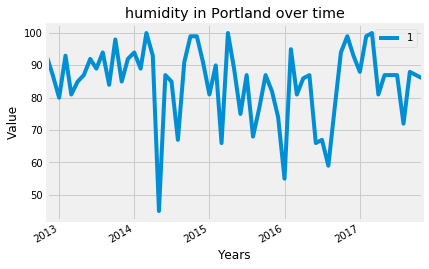

In [19]:
def years_plot(city='Portland',parameter='humidity',frequency = 'M'):
    string = "Select datetime,\""+city+"\" from "+ parameter +";"
    [names,parameter_list] = select(conn,string)
    
    #converting to dataframe
    city_parameter = pd.DataFrame(parameter_list)
    
    #setting datetime as index
    city_parameter = city_parameter.set_index([0])
    city_parameter.index = pd.to_datetime(city_parameter.index)
    
    #plot
    city_parameter.asfreq(frequency).plot()
    plt.title(parameter + ' in '+ city +' over time')
    plt.xlabel('Years')
    plt.ylabel('Value')
    plt.show()

##
years_plot('Portland','humidity','M')

### Ploting Given City and Parameter Over a Year Function

In [20]:
def yearly_plot(city='Portland',parameter='humidity',frequency = 'M',year=2016):  
    string = "Select datetime,\""+city+"\" from "+ parameter +" WHERE datetime LIKE '"+ str(year) +"%';"
    [names,parameter_list] = select(conn,string)
    
    #converting to dataframe
    city_parameter = pd.DataFrame(parameter_list)
    
    #setting datetime as index
    city_parameter = city_parameter.set_index([0])
    city_parameter.index = pd.to_datetime(city_parameter.index)
    
    #plot
    city_parameter.asfreq(frequency).plot()
    plt.title(parameter + ' in '+ city +' City over time for a year' + str(year))
    plt.xlabel('Month')
    plt.ylabel('Value')
    plt.show()

    
##
yearly_plot('Portland','humidity','W',2016)

TypeError: 'str' object is not callable

## Plotting Given City and Parameter over Year Stacked for Comparision

In [ ]:
'''def yearly_stacked_plot(city='Portland',parameter='humidity',frequency = 'M',years=[2016]):
    for year in years: 
        string = "Select datetime,\""+city+"\" from "+ parameter +" WHERE datetime LIKE '"+ str(year) +"%';"
        [names,parameter_list] = select(conn,string)
        
        datetime = []
        for element in parameter_list:
            datetime.append(str(element)[7:21])
            
        city_datatime = pd.DataFrame(datetime)
        
        #converting to dataframe
        city_parameter = pd.DataFrame(parameter_list)
        
        city_parameter['datetime'] = city_datatime
        
        #setting datetime as index
        city_parameter = city_parameter.set_index(['datetime'])
        city_parameter.index = pd.to_datetime(city_parameter.index,format="%m-%d %H:%M:%S",errors='ignore')
        
        #plot
        
        city_parameter.asfreq(frequency).plot()
        #plt.title(parameter + ' in '+ city +' City over time for a year' + str(year))

##
plt.figure(figsize =(20,20))
yearly_stacked_plot('Portland','humidity','M',[2014,2015])
'''

### City Parameter Graph Function

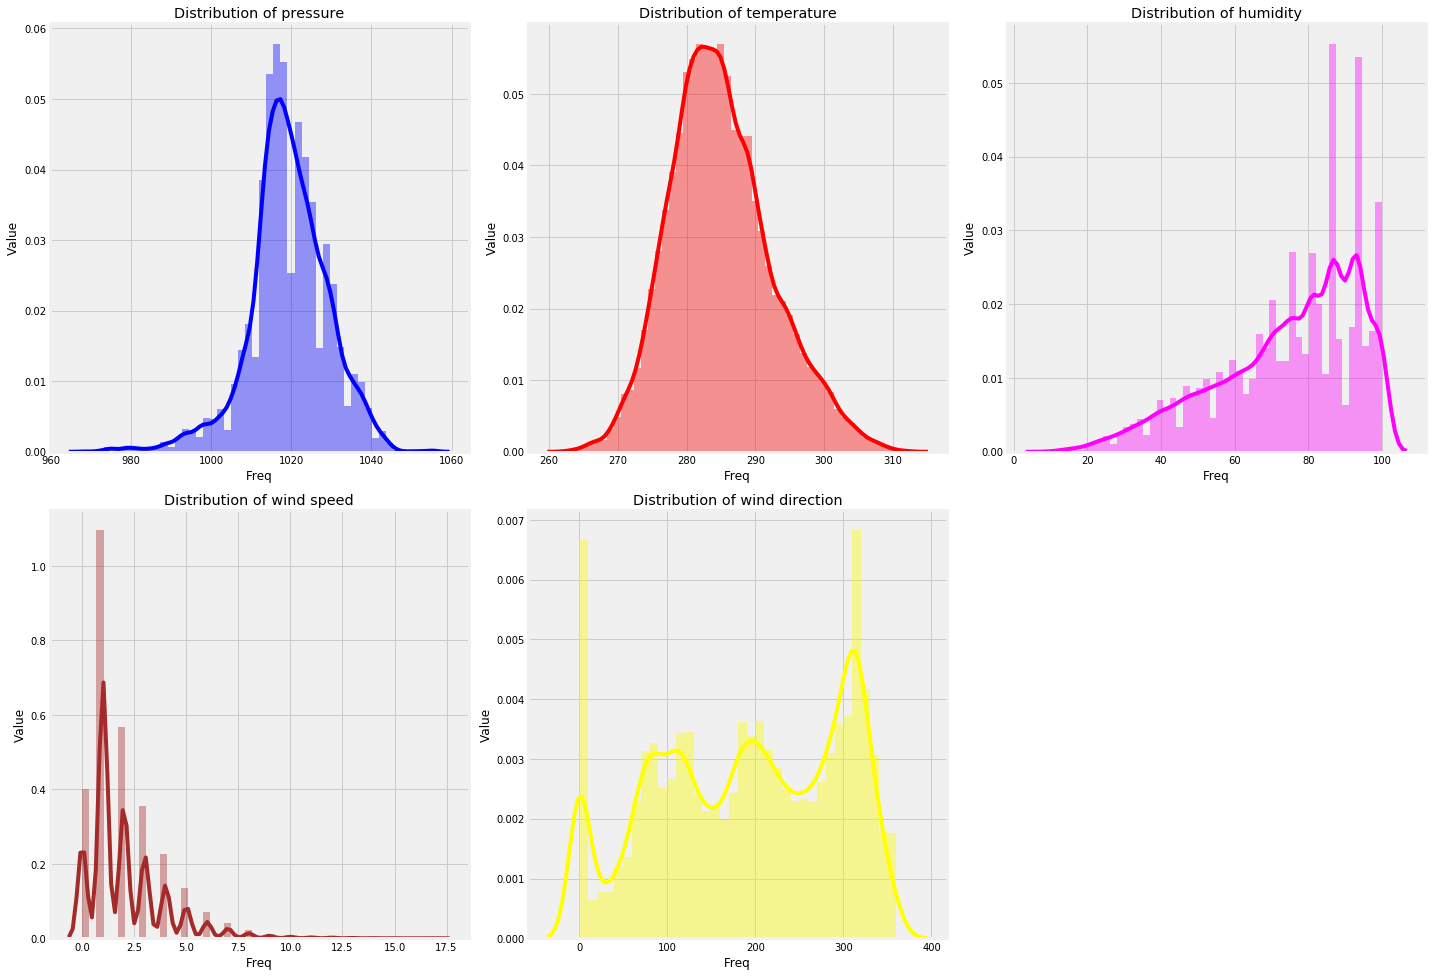

In [21]:
def city_parameter(city='Portland'):
    
    plt.figure(figsize =(20,20))
    
    #defining subplot
    plt.subplot(3,3,1)
    
    string = "Select datetime,\""+city+"\" from pressure;"
    [names,pressure_list] = select(conn,string)
    
    #converting to dataframe
    city_pressure = pd.DataFrame(pressure_list)
    
    #setting datetime as index
    city_pressure = city_pressure.set_index([0])
    city_pressure.index = pd.to_datetime(city_pressure.index)
    
    city_pressure = city_pressure.dropna()
    
    sns.distplot(city_pressure,color='blue')
    plt.title('Distribution of pressure')
    plt.xlabel('Freq')
    plt.ylabel('Value')
    
    #defining subplot
    plt.subplot(3,3,2)
    
    string = "Select datetime,\""+city+"\" from temperature;"
    [names,temperature_list] = select(conn,string)
    
    #converting to dataframe
    city_temperature = pd.DataFrame(temperature_list)
    
    #setting datetime as index
    city_temperature = city_temperature.set_index([0])
    city_temperature.index = pd.to_datetime(city_temperature.index)
    
    city_temperature = city_temperature.dropna()
    
    sns.distplot(city_temperature,color='red')
    plt.title('Distribution of temperature')
    plt.xlabel('Freq')
    plt.ylabel('Value')
    
    #defining subplot
    plt.subplot(3,3,3)
    
    string = "Select datetime,\""+city+"\" from humidity;"
    [names,humidity_list] = select(conn,string)
    
    #converting to dataframe
    city_humidity = pd.DataFrame(humidity_list)
    
    #setting datetime as index
    city_humidity = city_humidity.set_index([0])
    city_humidity.index = pd.to_datetime(city_humidity.index)
    
    city_humidity = city_humidity.dropna()
    
    sns.distplot(city_humidity,color='magenta')
    plt.title('Distribution of humidity')
    plt.xlabel('Freq')
    plt.ylabel('Value')
    
    #defining subplot
    plt.subplot(3,3,4)
    
    string = "Select datetime,\""+city+"\" from wind_speed;"
    [names,windspeed_list] = select(conn,string)
    
    #converting to dataframe
    city_windspeed = pd.DataFrame(windspeed_list)
    
    #setting datetime as index
    city_windspeed = city_windspeed.set_index([0])
    city_windspeed.index = pd.to_datetime(city_windspeed.index)
    
    city_windspeed = city_windspeed.dropna()
    
    sns.distplot(city_windspeed,color='brown')
    plt.title('Distribution of wind speed')
    plt.xlabel('Freq')
    plt.ylabel('Value')
    
    #defining subplot
    plt.subplot(3,3,5)
    
    string = "Select datetime,\""+city+"\" from wind_direction;"
    [names,winddirection_list] = select(conn,string)
    
    #converting to dataframe
    city_winddirection = pd.DataFrame(winddirection_list)
    
    #setting datetime as index
    city_winddirection = city_winddirection.set_index([0])
    city_winddirection.index = pd.to_datetime(city_winddirection.index)
    
    city_winddirection = city_winddirection.dropna()
    
    sns.distplot(city_winddirection,color='yellow')
    plt.title('Distribution of wind direction')
    plt.xlabel('Freq')
    plt.ylabel('Value')
    
    plt.tight_layout()
    plt.show()
    
##
city_parameter()

### Parameter Relation Function

In [ ]:
def parameter_relation(city='Portland',parameter1='humdity',parameter2='temperature'):
    
    string = "Select datetime,\""+city+"\" from "+ parameter1 +";"
    [names,parameter1_list] = select(conn,string)
    
    #converting to dataframe
    city_parameter1 = pd.DataFrame(parameter1_list)
    
    #setting datetime as index
    city_parameter1 = city_parameter1.set_index([0])
    city_parameter1.index = pd.to_datetime(city_parameter1.index)
    
    #city_parameter1 = city_parameter1.dropna()
    
    string = "Select datetime,\""+city+"\" from "+ parameter2 +";"
    [names,city_parameter2_list] = select(conn,string)
    
    #converting to dataframe
    city_parameter2 = pd.DataFrame(city_parameter2_list)
    
    #setting datetime as index
    city_parameter2 = city_parameter2.set_index([0])
    city_parameter2.index = pd.to_datetime(city_parameter2.index)
    
    #city_parameter2 = city_parameter2.dropna()
    
    plt.scatter(x=city_parameter1,y=city_parameter2,color='orange')
    plt.title(parameter1 + ' vs '+ parameter2)
    plt.xlabel(parameter1)
    plt.ylabel(parameter2)
    plt.show()
    
##
parameter_relation('New York','pressure','wind_speed')

### Weather Description Function

In [ ]:
def city_weather_description(city='Boston'):
    
    plt.figure(figsize=(30,30))
    
    string = """Select p.datetime,p.["""+city+"""],wd.["""+city+"""]
                 from pressure as p
                 INNER JOIN weather_description as wd on p.datetime=wd.datetime"""
    
    [names,pressure_description_list] = select(conn,string)
    
    #converting to dataframe
    city_pressure_description = pd.DataFrame(pressure_description_list)
    
    #setting datetime as index
    city_pressure_description = city_pressure_description.set_index([0])
    city_pressure_description.index = pd.to_datetime(city_pressure_description.index)
    
    city_pressure_description.groupby(2).count()[1].plot(kind='bar',color='purple')
    plt.title('Count of Weather Description',fontsize= 30)
    plt.xlabel('Weather Description', fontsize= 30)
    plt.rcParams.update({'font.size': 30})
    
  
##
city_weather_description()

### City Monthly Parameter Flactualtion Function

In [ ]:
def parameter_monthly_flctuations(city='Portland'):
    
    #plot figure
    plt.figure(figsize=(15,15))
    
    #SQL
    string = "Select datetime,\""+city+"\" from temperature;"
    [names,temperature_list] = select(conn,string)

    #convert ing to dataframe
    city_temperature = pd.DataFrame(temperature_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_temperature[0])
    city_temperature['month']=time.month

    plt.subplot(3,3,1)
    plot_temperature = sns.boxplot(x='month',y=1,data=city_temperature)
    plot_temperature.set(ylabel="Tempreture")
    plt.title('Temperature across month box plot')
    
    #SQL
    string = "Select datetime,\""+city+"\" from pressure;"
    [names,pressure_list] = select(conn,string)

    #convert ing to dataframe
    city_pressure = pd.DataFrame(pressure_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_pressure[0])
    city_pressure['month']=time.month
    
    plt.subplot(3,3,2)
    plot_pressure = sns.boxplot(x='month',y=1,data=city_pressure)
    plot_pressure.set(ylabel="Pressure")
    plt.title('Pressure across month box plot')
    
    #SQL
    string = "Select datetime,\""+city+"\" from humidity;"
    [names,humidity_list] = select(conn,string)

    #convert ing to dataframe
    city_humidity = pd.DataFrame(humidity_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_humidity[0])
    city_humidity['month']=time.month
    
    plt.subplot(3,3,3)
    plot_humidity = sns.boxplot(x='month',y=1,data=city_humidity)
    plot_humidity.set(ylabel="Humidity")
    plt.title('Humidity across month box plot')
    
    #SQL
    string = "Select datetime,\""+city+"\" from wind_speed;"
    [names,windspeed_list] = select(conn,string)

    #convert ing to dataframe
    city_windspeed = pd.DataFrame(windspeed_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_windspeed[0])
    city_windspeed['month']=time.month
    
    plt.subplot(3,3,4)
    plot_windspeed = sns.boxplot(x='month',y=1,data=city_windspeed)
    plot_windspeed.set(ylabel="Wind speed")
    plt.title('Wind speed across month box plot')
    
    #SQL
    string = "Select datetime,\""+city+"\" from wind_direction;"
    [names,winddirection_list] = select(conn,string)

    #convert ing to dataframe
    city_winddirection = pd.DataFrame(winddirection_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_winddirection[0])
    city_winddirection['month']=time.month
    
    plt.subplot(3,3,5)
    plot_winddirection = sns.boxplot(x='month',y=1,data=city_winddirection)
    plot_winddirection.set(ylabel="Wind direction")
    
    plt.title('Wind direction across month box plot')
    plt.tight_layout()
    plt.show()
parameter_monthly_flctuations()

### City Weekly Parameter Flactualtion Over Function

In [ ]:
def parameter_weekly_flctuations(city='Portland'):

    #plot figure
    plt.figure(figsize=(15,15))

    #SQL
    string = "Select datetime,\""+city+"\" from temperature;"
    [names,temperature_list] = select(conn,string)

    #convert ing to dataframe
    city_temperature = pd.DataFrame(temperature_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_temperature[0])
    city_temperature['week']=time.week

    plt.subplot(3,3,1)
    plot_temperature = sns.lineplot(x='week',y=1,data=city_temperature)
    plot_temperature.set(ylabel="Tempreture")
    plt.title('Temperature across week box plot')

    #SQL
    string = "Select datetime,\""+city+"\" from pressure;"
    [names,pressure_list] = select(conn,string)

    #convert ing to dataframe
    city_pressure = pd.DataFrame(pressure_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_pressure[0])
    city_pressure['week']=time.week

    plt.subplot(3,3,2)
    plot_pressure = sns.lineplot(x='week',y=1,data=city_pressure)
    plot_pressure.set(ylabel="Pressure")
    plt.title('Pressure across month box plot')

    #SQL
    string = "Select datetime,\""+city+"\" from humidity;"
    [names,humidity_list] = select(conn,string)

    #convert ing to dataframe
    city_humidity = pd.DataFrame(humidity_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_humidity[0])
    city_humidity['week']=time.week

    plt.subplot(3,3,3)
    plot_humidity = sns.lineplot(x='week',y=1,data=city_humidity)
    plot_humidity.set(ylabel="Humidity")
    plt.title('Humidity across week box plot')

    #SQL
    string = "Select datetime,\""+city+"\" from wind_speed;"
    [names,windspeed_list] = select(conn,string)

    #convert ing to dataframe
    city_windspeed = pd.DataFrame(windspeed_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_windspeed[0])
    city_windspeed['week']=time.week

    plt.subplot(3,3,4)
    plot_windspeed = sns.lineplot(x='week',y=1,data=city_windspeed)
    plot_windspeed.set(ylabel="Wind speed")
    plt.title('Wind speed across week box plot')

    #SQL
    string = "Select datetime,\""+city+"\" from wind_direction;"
    [names,winddirection_list] = select(conn,string)

    #convert ing to dataframe
    city_winddirection = pd.DataFrame(winddirection_list)

    #setting datetime as index
    time = pd.DatetimeIndex(city_winddirection[0])
    city_winddirection['week']=time.week

    plt.subplot(3,3,5)
    plot_winddirection = sns.lineplot(x='week',y=1,data=city_winddirection)
    plot_winddirection.set(ylabel="Wind direction")

    plt.title('Wind direction across week box plot')
    plt.tight_layout()
    plt.show()
parameter_weekly_flctuations()

In [ ]:
Yr_df = pd.read_sql_query("SELECT DISTINCT Yr from USA_Historical_Tornado", conn)
Tor_df = pd.read_sql_query("SELECT st,len,\"start lat\",\"start lon\",\"fin lat\",\"fin lon\" from USA_Historical_Tornado WHERE Yr = 1950", conn)
City_at_df = pd.read_sql_query("Select City,Latitude,Longitude from cities WHERE country = 'United States'", conn)

In [ ]:
Yr_list = Yr_df['Yr'].values.tolist()

In [ ]:
m=widgets.Dropdown(
    options=Yr_list,
    description='Year:',
    disabled=False,
)
display(m)
fig = go.Figure()


fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = Tor_df['start lon'],
        lat = Tor_df['start lat'],
        text = Tor_df['st'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=0.1,
                color='black'
            ),
            colorscale = 'darkmint',
            cmin = 0,
            color = Tor_df['len'],
            cmax = Tor_df['len'].max(),
            colorbar_title="Length of Tornadoes"
        )))

fig.add_trace(go.Scattergeo(
    locationmode = 'USA-states',
    text = City_at_df['City'],   
    lon = City_at_df['Longitude'],
    lat = City_at_df['Latitude'],
    mode = 'markers+text',
    textposition = 'bottom center',
    marker_color = 'maroon',
    ))


fig.update_layout(
    title_text = 'Tornadoes in the Year 1950',
    showlegend = False,
    geo = go.layout.Geo(
        scope = 'usa',
        projection_type = 'albers usa',
        showland = True,
        landcolor = 'lightgray',
        countrycolor = 'white',
    ),
)

fig.show()

def on_change(change):
    clear_output()
    display(m)
    input_val=str(change['owner'])[-5:-1]
    Tor_df = pd.read_sql_query("SELECT st,len,\"start lat\",\"start lon\",\"fin lat\",\"fin lon\" from USA_Historical_Tornado WHERE Yr ="+input_val, conn)
    
    fig = go.Figure()

    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        lon = Tor_df['start lon'],
        lat = Tor_df['start lat'],
        text = Tor_df['st'],
        mode = 'markers',
        marker = dict(
            size = 8,
            opacity = 0.8,
            reversescale = False,
            autocolorscale = False,
            symbol = 'square',
            line = dict(
                width=0.1,
                color='black'
            ),
            colorscale = 'darkmint',
            cmin = 0,
            color = Tor_df['len'],
            cmax = Tor_df['len'].max(),
            colorbar_title="Length of Tornadoes"
    )))

    fig.add_trace(go.Scattergeo(
        locationmode = 'USA-states',
        text = City_at_df['City'],   
        lon = City_at_df['Longitude'],
        lat = City_at_df['Latitude'],
        mode = 'markers+text',
        textposition = 'bottom center',
        marker_color = 'maroon',
    ))


    fig.update_layout(
        title_text = 'Tornadoes in the Year '+input_val,
        showlegend = False,
        geo = go.layout.Geo(
            scope = 'usa',
            projection_type = 'albers usa',
            showland = True,
            landcolor = 'lightgray',
            countrycolor = 'white',
        ),
    )

    fig.show()
m.observe(on_change)
    